# This tutorial describes how to use A Framework for Bayesian Optimization in Embedded Subspaces, which is implemented in python.

Nina MOELLO ONERA/DTIS/M2CI - May 2020

<p class="alert alert-success" style="padding:1em">
To use this framework, please follow this link : https://github.com/aminnayebi/HesBO. 
</p>

The reference paper is available 
here http://proceedings.mlr.press/v97/nayebi19a/nayebi19a.pdf (HeSBO)
https://ml.informatik.uni-freiburg.de/papers/16-JAIR-REMBO.pdf (REMBO)

This repository provides Python implementations of several algorithms that extend BO to problems with high input dimensions:

The HeSBO algorithm proposed by Munteanu, Nayebi, and Poloczek (ICML '19) combined with

- The Knowledge Gradient (KG) algorithm of Cornell-MOE (Wu & Frazier NIPS'16; Wu, Poloczek, Wilson, and Frazier NIPS'17)

- The BLOSSOM algorithm of McLeod, Osborne, and Roberts (ICML '18)

- Expected improvement, e.g., see Jones, Schonlau, and Welch (JGO '98)

The REMBO method using

- the $K_X$ and $K_y$ kernels of Wang et al. (JMLR '18) and

- the $K_{\psi}$ kernel of Binois, Ginsbourger and Roustant (LION '15).

Note that HeSBO and REMBO are maximization algorithms, so please make sure you reformulate potential minimization problems.

## Installing the requirements

The codes are written in python 3.6, so it is recommended to use this version of python to run the scripts. To install the requirements one can simply use this line:

Also, some test functions presented here depend on the smt package (https://github.com/SMTorg/smt) and the segolight package (on the ONERA SVN). 

## Set up an optimization problem class

The functions.py folder contains the optimization problem classes, the functions are then written and defined there. Calling the function is done in the 'Runmain' (in count_sketch.py for HeSBO or REMBO.py for REMBO), parameter 'func_type'.

In [1]:
#from function.py
import math
import numpy as np
# import matlab.engine
# import torch
# from BOCK_benchmarks.mnist_weight import mnist_weight
# All functions are defined in such a way that have global maximums,
# if a function originally has a minimum, the final objective value is multiplied by -1

class TestFunction:
    def evaluate(self,x):
        pass

### From analytical expression

In [2]:
class Rosenbrock(TestFunction):
    def __init__(self, act_var, noise_var=0):
        self.range=np.array([[-2,2],
                             [-2,2]])
        self.act_var=act_var
        self.var = noise_var

    def scale_domain(self,x):
        # Scaling the domain
        x_copy = np.copy(x)
        if len(x_copy.shape) == 1:
            x_copy = x_copy.reshape((1, x_copy.shape[0]))
        for i in range(len(self.range)):
            x_copy[:, i] = x_copy[:, i] * (self.range[i,1] - self.range[i,0]) / 2 + (
                    self.range[i,1] + self.range[i,0]) / 2
        return x_copy

    def evaluate_true(self,x):
        # Calculating the output
        scaled_x=self.scale_domain(x)
        f = [[0]]
        f[0] = [-(math.pow(1 - i[self.act_var[0]], 2) + 100 * math.pow(i[self.act_var[1]] - math.pow(i[self.act_var[0]], 2), 2)) for i in scaled_x]
        f = np.transpose(f)
        return f

    def evaluate(self, x):
        scaled_x = self.scale_domain(x)
        n = len(scaled_x)
        return self.evaluate_true(x) + np.random.normal(0,self.var,(n,1))

### From segolight

In [3]:
class Branin(TestFunction):
    def __init__(self, act_var=None, noise_var=0, high_dim=100):
        self.range = np.array([[-1, 1],
                               [-1, 1]])
        self.dim=high_dim

    def evaluate_true(self,x):
        _x = np.atleast_2d(x)
        f = [[0]]
        f[0] = [get_case_branin(self.dim)['f_obj'](x_i)[0] for x_i in _x]
        f = np.transpose(f)
        file.close()
        return -f

    def evaluate(self, x):
        return self.evaluate_true(x)
    
class Rover(TestFunction):           
    def __init__(self, act_var=None, noise_var=0, high_dim=60):
        self.range = np.array([[-1, 1],
                               [-1, 1]])
        self.dim=high_dim

    def evaluate_true(self,x):
        _x = np.atleast_2d(x)
        f = [[0]]
        case_rov = get_case_rov()
        f[0]= [case_rov['f_obj'](x)[0] for x_i in _x]
        f = np.transpose(f)
        file.close()
        return -f

    def evaluate(self, x):
        return self.evaluate_true(x)

## Create a HeSBO optimizer instance

In count_sketch.py. It calls the functions (written in the functions.py folder) as 'func_type'.

In [4]:
import GPy
# import matlab.engine
import numpy as np
from pyDOE import lhs
import functions
from REMBO import EI
import timeit
from Nina_HesBO import RunMain

### Specifying the type of objective function

In [5]:
def func(active_var, noise_var, high_dim):  
    if func_type=='Branin':
        test_func = functions.Branin(active_var, noise_var, high_dim)
    elif func_type=='Rosenbrock':
        test_func = functions.Rosenbrock(active_var, noise_var=noise_var)
    elif func_type=='Rover':
        test_func=functions.Rover(active_var, noise_var=noise_var)
    else:
        TypeError('The input for func_type variable is invalid, which is', func_type)
    return test_func

### Run the optimization process

In [6]:
res, time, s, f_s, f_s_true, _, low_dim, high_dim, initial_n, total_itr, func_type=RunMain(
    high_dim=20, # The dimension of high dimensional search space
    low_dim=2, # The effective dimension of the algorithm
    initial_n=20, # The number of initial points
    total_itr=40, # The number of iterations of algorithm. The total number of test function evaluations is initial_n + total_itr
    func_type='Branin', # The name of test function, defined in the function.py folder
    s=None, # Initial points, 'None' or folder path (.npy)
    active_var=None, # A vector with the size of greater or equal to the number of active variables of test function. The values of vector are integers less than high_dim value.
    ARD=False, # If TRUE, kernel is isomorphic
    variance=1, # Signal variance of the kernel
    length_scale=None, # Length scale values of the kernel
    box_size=None, # This variable indicates the search space [-box_size, box_size]^d
    high_to_low=None, # A vector with D elements. each element can have a value from {0,..,d-1}
    sign=None, # A vector with D elements. each element is either +1 or -1.
    hyper_opt_interval=20, # The number of iterations between two consecutive hyper parameters optimizations
    noise_var=0, # Noise variance of the test functions
)
    #return: a tuple of best values of each iteration, all observed points, and corresponding test function values of observed points

 D:\rpriem\Anaconda3\envs\HesBO\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


### Plot the result

[[-32.90597793 -32.90597793 -22.4106716  -22.4106716  -22.4106716
  -22.4106716  -22.4106716  -13.27814094 -13.27814094 -13.27814094
  -13.27814094 -13.27814094 -13.27814094 -13.27814094 -13.27814094
  -13.27814094 -13.27814094 -13.27814094 -12.52134732 -12.52134732
   -9.44898916  -9.44898916  -9.44898916  -9.44898916  -9.44898916
   -9.44898916  -9.44898916  -9.44898916  -9.42730495  -9.42730495
   -9.42730495  -9.42730495  -9.42730495  -9.42730495  -9.42730495
   -9.42730495  -9.42730495  -9.42730495  -9.42730495  -9.42730495
   -9.42730495  -9.42730495  -9.42730495  -9.42730495  -9.42730495
   -9.42730495  -9.42730495  -9.42730495  -9.42730495  -9.42730495
   -9.42730495  -9.42730495  -9.42730495  -9.42730495  -9.42730495
   -9.42730495  -9.42730495  -9.42730495  -9.42730495  -9.42730495]] [[0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.6

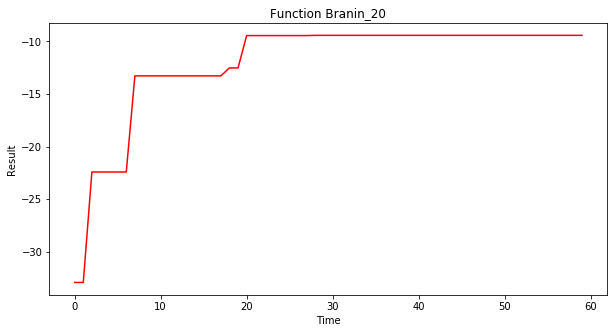

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5) )
print(res,time)
plt.title('Function %s_%i' %(func_type,high_dim))
plt.xlabel('Time')
plt.ylabel('Result')
plt.plot(list(range(len(res.T))),res.T,'r')
plt.show()

## Create a REMBO optimizer instance

In REMBO.py. It calls the functions (written in the functions.py folder) as 'func_type'.

In [8]:
import GPy
# import matlab.engine
import numpy as np
import math
from pyDOE import lhs
from scipy.stats import norm
import functions
import projection_matrix
import projections
import kernel_inputs
import timeit
from Nina_Rembo import RunRembo

### Specifying the type of objective function

In [9]:
def func(active_var, noise_var, high_dim):  
    if func_type=='Branin':
        test_func = functions.Branin(active_var, noise_var, high_dim)
    elif func_type=='Rosenbrock':
        test_func = functions.Rosenbrock(active_var, noise_var=noise_var)
    elif func_type=='Rover':
        test_func=functions.Rover(active_var, noise_var=noise_var)
    else:
        TypeError('The input for func_type variable is invalid, which is', func_type)
    return test_func

### Specifying the type of embedding matrix

In [10]:
def emb(low_dim,high_dim,matrix_type):
    if matrix_type=='simple':
        matrix=projection_matrix.SimpleGaussian(low_dim, high_dim)
    elif matrix_type=='normal':
        matrix= projection_matrix.Normalized(low_dim, high_dim)
    elif matrix_type=='orthogonal':
        matrix = projection_matrix.Orthogonalized(low_dim, high_dim)
    else:
        TypeError('The input for matrix_type variable is invalid, which is', matrix_type)
    return matrix

### Specifying the input type of kernel

In [11]:
def ker(kern_inp_type, A)   :
    if kern_inp_type=='Y':
        kern_inp = kernel_inputs.InputY(A)
        input_dim=low_dim
    elif kern_inp_type=='X':
        kern_inp = kernel_inputs.InputX(A)
        input_dim = high_dim
    elif kern_inp_type == 'psi':
        kern_inp = kernel_inputs.InputPsi(A)
        input_dim = high_dim
    else:
        TypeError('The input for kern_inp_type variable is invalid, which is', kern_inp_type)
    return input_dim,kern_inp

### Run the optimization process

In [12]:
res,time, s, f_s, fs_true, high_s,low_dim, high_dim, initial_n, total_itr, func_type =RunRembo(

    low_dim=2, # the dimension of low dimensional search space
    high_dim=20, # the dimension of high dimensional search space
    initial_n=20, # the number of initial points
    total_itr=40, # the number of iterations of algorithm. The total number of test function evaluations is initial_n + total_itr
    func_type='Branin', # the name of test function, defined in the function.py folder
    matrix_type='simple', # the type of projection matrix
    kern_inp_type='Y', # the type of projection. Projected points are used as the input of kernel
    A_input=None, # a projection matrix with iid gaussian elements. The size of matrix is low_dim * high_dim
    s=None, # initial points, 'None' or folder path (.npy)
    active_var=None, # a vector with the size of greater or equal to the number of active variables of test function. The values of vector are integers less than high_dim value.
    hyper_opt_interval=20, # the number of iterations between two consecutive hyper parameters optimizations
    ARD=False, # if TRUE, kernel is isomorphic
    variance=1., # signal variance of the kernel
    length_scale=None, # length scale values of the kernel
    box_size=None, # this variable indicates the search space [-box_size, box_size]^d
    noise_var=0, # noise variance of the test functions
)   
    
    #return: a tuple of best values of each iteration, all observed points, and corresponding test function values of observed points

### Plot the result

[[21.50254847 21.50254847 21.50254847 21.50254847 18.6181675  18.6181675
  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675
  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675
  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675
  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675  18.6181675
  18.44058342 18.44058342 18.44058342 18.39971174 18.39971174 18.39971174
  18.39971174 18.39971174 18.39971174 18.39971174 18.39971174 18.39971174
  18.39971174 18.39971174 18.39971174 18.39971174 18.39971174 18.39971174
  18.39971174 18.33963041 18.33963041 18.33963041 18.33963041 18.33963041
  18.33963041 18.33963041 18.33963041 18.33963041 18.33963041 18.33963041]] [[0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.        0.        0.        0.        0.        0.        0.5420055
  0.507783  0.5285773 0.5226535 0.5345121 0.5422848 0.5478024

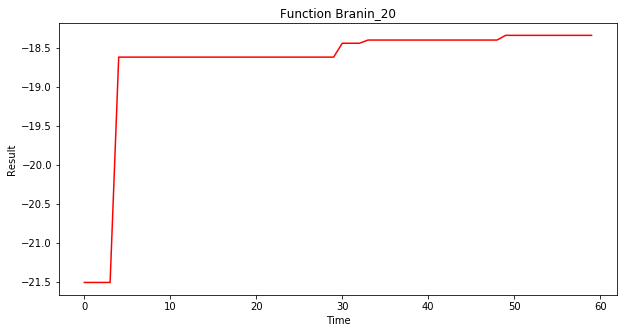

In [13]:
print(-res,time)
fig = plt.figure(figsize=(10,5) )
plt.title('Function %s_%i' %(func_type,high_dim))
plt.xlabel('Time')
plt.ylabel('Result')
plt.plot(list(range(len(res.T))),res.T,'r')
plt.show()